# Price Gaps in causality

In [142]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import uniform, normal, binomial, choice
from sklearn.linear_model import Ridge

import graphviz as gr
import pandas as pd

def simulate(**kwargs):
  """Helper function to simulate and plot a causal function"""
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

Create an example with price gaps

,our_price,comp_price,price_gap,demand
0,21.99,12.99,9.0,478.968177
1,22.99,15.99,7.0,481.894830
2,20.99,12.99,8.0,475.176716
3,22.99,12.99,10.0,471.411370
4,22.99,13.99,9.0,477.291099


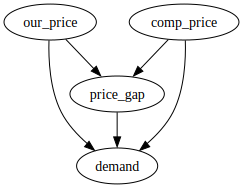

In [379]:
np.random.seed(42)

N = 200

df, g = simulate(
    our_price = lambda: choice([18.99, 19.99, 20.99, 21.99, 22.99, 23.99], N),
    comp_price = lambda: choice([12.99, 13.99, 14.99, 15.99, 16.99], N),
    price_gap = lambda our_price, comp_price: our_price - comp_price,
    demand = lambda our_price, comp_price, price_gap: normal(500 + (-1.7 * our_price) + (1.6 * comp_price) + (-1.25 * price_gap), 5)
)
display(df.head())
g

In [380]:
df.corr()

,our_price,comp_price,price_gap,demand
our_price,1.000000,0.037478,0.758897,-0.543565
comp_price,0.037478,1.000000,-0.622311,0.503714
price_gap,0.758897,-0.622311,1.000000,-0.754039
demand,-0.543565,0.503714,-0.754039,1.000000


So yeah, we know multicollinearity is going to be bad here so I don't expect to see good estimates from OLS whenever we include it.

In [381]:
X = df[['our_price', 'comp_price', 'price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.566    
Dependent Variable: demand           AIC:                1218.7708
Date:               2024-01-11 16:32 BIC:                1228.6657
No. Observations:   200              Log-Likelihood:     -606.39  
Df Model:           2                F-statistic:        130.8    
Df Residuals:       197              Prob (F-statistic): 7.01e-37 
R-squared:          0.571            Scale:              25.562   
------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
const          492.1000   5.8683  83.8569 0.0000 480.5272 503.6728
our_price       -0.7548   0.1633  -4.6229 0.0000  -1.0767  -0.4328
comp_price       1.0637   0.1828   5.8190 0.0000   0.7032   1.4241
price_gap       -1.8184   0.1133 -16.0510 0.0000  -2.0418  -1.5950
------------------------------------------------------------------
Omnibus:          4.489     Durbin-Watson:       1.963            
Prob(Omnibus):    0.106     Jarque-Bera (JB):    3.548            
Skew:             -0.212    Prob(JB):            0.170            
Kurtosis:         2.505     Condition No.:       25342205754188680
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The smallest eigenvalue is 2.28e-28. This might indicate that
there are strong multicollinearity problems or that the design
matrix is singular.
"""

Super bad

In [382]:
# Just prices?
X = df[['our_price', 'comp_price']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.566    
Dependent Variable: demand           AIC:                1218.7708
Date:               2024-01-11 16:32 BIC:                1228.6657
No. Observations:   200              Log-Likelihood:     -606.39  
Df Model:           2                F-statistic:        130.8    
Df Residuals:       197              Prob (F-statistic): 7.01e-37 
R-squared:          0.571            Scale:              25.562   
------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
const          492.1000   5.8683  83.8569 0.0000 480.5272 503.6728
our_price       -2.5732   0.2135 -12.0543 0.0000  -2.9941  -2.1522
comp_price       2.8821   0.2566  11.2322 0.0000   2.3761   3.3881
------------------------------------------------------------------
Omnibus:              4.489         Durbin-Watson:           1.963
Prob(Omnibus):        0.106         Jarque-Bera (JB):        3.548
Skew:                 -0.212        Prob(JB):                0.170
Kurtosis:             2.505         Condition No.:           431  
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

...

In [383]:
X = df[['our_price', 'price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.566    
Dependent Variable: demand           AIC:                1218.7708
Date:               2024-01-11 16:32 BIC:                1228.6657
No. Observations:   200              Log-Likelihood:     -606.39  
Df Model:           2                F-statistic:        130.8    
Df Residuals:       197              Prob (F-statistic): 7.01e-37 
R-squared:          0.571            Scale:              25.562   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const      492.1000    5.8683   83.8569  0.0000  480.5272  503.6728
our_price    0.3089    0.3276    0.9430  0.3468   -0.3371    0.9549
price_gap   -2.8821    0.2566  -11.2322  0.0000   -3.3881   -2.3761
------------------------------------------------------------------
Omnibus:              4.489         Durbin-Watson:           1.963
Prob(Omnibus):        0.106         Jarque-Bera (JB):        3.548
Skew:                 -0.212        Prob(JB):                0.170
Kurtosis:             2.505         Condition No.:           373  
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

No good here

In [384]:
X = df[['price_gap']]
y = df['demand']

mod = sm.OLS(y, sm.add_constant(X))
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.566    
Dependent Variable: demand           AIC:                1217.6716
Date:               2024-01-11 16:32 BIC:                1224.2682
No. Observations:   200              Log-Likelihood:     -606.84  
Df Model:           1                F-statistic:        260.9    
Df Residuals:       198              Prob (F-statistic): 5.37e-38 
R-squared:          0.569            Scale:              25.547   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const      497.5226    1.1717  424.6115  0.0000  495.2119  499.8332
price_gap   -2.6984    0.1670  -16.1538  0.0000   -3.0279   -2.3690
------------------------------------------------------------------
Omnibus:              3.971         Durbin-Watson:           1.959
Prob(Omnibus):        0.137         Jarque-Bera (JB):        3.367
Skew:                 -0.222        Prob(JB):                0.186
Kurtosis:             2.546         Condition No.:           23   
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

Looks like there's just no way to really estimate it here unless the true impact of the price gap is that much larger than the prices themselves - not likely. 

## Ridge

Okay, how about Ridge regression to help regularize...

In [385]:
ridge_model = Ridge(alpha=1)
X = df[['our_price', 'comp_price', 'price_gap']]
y = df['demand']
ridge_model.fit(X, y)
ridge_model.coef_

array([-0.75473201,  1.06227151, -1.81700352])

Same issue